# TECHNICAL PAPER AIML CA1

# Modelling Objective

> Can we utilize machine learning to assist customers and owners to indicate the price of an AirBnb listing?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display
import re
import warnings
warnings.filterwarnings('ignore')
sns.set()

from sklearn.base import BaseEstimator, TransformerMixin

# Model evaluation
from sklearn.model_selection import train_test_split, cross_validate, KFold, learning_curve, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import SCORERS,make_scorer,mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error

# preprocessing
from sklearn.pipeline import Pipeline,make_pipeline,FeatureUnion
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer, PolynomialFeatures, OneHotEncoder, FunctionTransformer,LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import MissingIndicator, SimpleImputer, IterativeImputer

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso,ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso,BayesianRidge,SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor,BaggingRegressor,AdaBoostRegressor

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.cluster import AgglomerativeClustering
# Feature Selection
from sklearn.feature_selection import SelectFromModel, RFECV, SelectKBest, VarianceThreshold, mutual_info_regression, RFE

Source: [Data from here](http://insideairbnb.com/get-the-data/)

For EDA purposes (branca/folium)

In [3]:
# pip install folium
# pip install branca

In [4]:
# Please install for EDA purposes
import phik
from phik import resources, report
from phik.report import plot_correlation_matrix

In [5]:
import folium
import branca.colormap as cm

## Dataset info:
1. Listings_df tells us complete and exhaustive aspects about the airbnb rental listings.
2. calendar_df tells us about the price over seasons

In [6]:
listings_df = pd.read_csv('datasets/listings.csv')
calendar_df = pd.read_csv('datasets/calendar.csv')
# Merge both
display(listings_df.head(3))
display(calendar_df.head(3))


id                           listing_url       scrape_id last_scraped  \
0   241032   https://www.airbnb.com/rooms/241032  20160104002432   2016-01-04   
1   953595   https://www.airbnb.com/rooms/953595  20160104002432   2016-01-04   
2  3308979  https://www.airbnb.com/rooms/3308979  20160104002432   2016-01-04   

                                  name  \
0         Stylish Queen Anne Apartment   
1   Bright & Airy Queen Anne Apartment   
2  New Modern House-Amazing water view   

                                             summary  \
0                                                NaN   
1  Chemically sensitive? We've removed the irrita...   
2  New modern house built in 2013.  Spectacular s...   

                                               space  \
0  Make your self at home in this charming one-be...   
1  Beautiful, hypoallergenic apartment in an extr...   
2  Our house is modern, light and fresh with a wa...   

                                         description experiences_offered  \
0  Make your self at home in this charming one-be...                none   
1  Chemically sensitive? We've removed the irrita...                none   
2  New modern house built in 2013.  Spectacular s...                none   

                               neighborhood_overview  ... review_scores_value  \
0                                                NaN  ...                10.0   
1  Queen Anne is a wonderful, truly functional vi...  ...                10.0   
2  Upper Queen Anne is a charming neighborhood fu...  ...                10.0   

  requires_license license jurisdiction_names instant_bookable  \
0                f     NaN         WASHINGTON                f   
1                f     NaN         WASHINGTON                f   
2                f     NaN         WASHINGTON                f   

  cancellation_policy  require_guest_profile_picture  \
0            moderate                              f   
1              strict                              t   
2              strict                              f   

  require_guest_phone_verification calculated_host_listings_count  \
0                                f                              2   
1                                t                              6   
2                                f                              2   

  reviews_per_month  
0              4.07  
1              1.48  
2              1.15  

[3 rows x 92 columns]

listing_id        date available   price
0      241032  2016-01-04         t  $85.00
1      241032  2016-01-05         t  $85.00
2      241032  2016-01-06         f     NaN

We can see that the id from both the datasets are the same, hence this means merging is needed.

In [7]:
print(set(listings_df['id']) - set(calendar_df['listing_id']))
print(set(calendar_df['listing_id']) - set(listings_df['id']))

set()
set()


In [8]:
listings_cnt = listings_df['id'].count()
hosts = len(listings_df['host_id'].unique())

print(f'Dataset contains information on {listings_cnt} listings provided by {hosts} hosts.'  )

Dataset contains information on 3818 listings provided by 2751 hosts.


## Data preparation before EDA:
1. Merge based on listing_id.
2. Dropping columns that are unnecessary, repeated, have full NULL values, and as well as features that do not even make sense for predicting target variable, such as `host_picture_url`.

In [9]:
listings_df = listings_df.rename(columns={"id": "listing_id"})
df = pd.merge(calendar_df, listings_df, on = 'listing_id')

drops = ['availability_30', 'availability_365', 'availability_60',
    'availability_90', 'available', 'calendar_last_scraped',
    'calendar_updated', 'city', 'cleaning_fee', 'country',
    'country_code', 'description', 'experiences_offered',
    'first_review', 'has_availability', 'host_about',
    'host_acceptance_rate', 'host_id', 'host_location', 'host_name',
    'host_neighbourhood', 'host_picture_url', 'host_thumbnail_url',
    'host_total_listings_count', 'host_url', 'is_location_exact',
    'jurisdiction_names', 'last_review', 'last_scraped',
    'license', 'listing_url', 'market', 'medium_url',
    'monthly_price', 'name', 'neighborhood_overview', 'neighbourhood',
    'neighbourhood_cleansed', 'notes', 'picture_url', 'price_y',
    'requires_license', 'reviews_per_month', 'scrape_id',
    'security_deposit', 'smart_location', 'space', 'square_feet',
    'state', 'street', 'summary', 'thumbnail_url', 'transit',
    'weekly_price', 'xl_picture_url','host_since','extra_people',
     'review_scores_accuracy', 'review_scores_cleanliness',
                         'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                        'review_scores_value', 'host_has_profile_pic', 'require_guest_profile_picture', 'instant_bookable'
                        ,'require_guest_phone_verification', 'cancellation_policy', 'calculated_host_listings_count']
df = df.drop(columns = drops)
display(df.shape)

(1393570, 26)

1. Dropping values from target variable that have been merged and are null, as that listing is NOT occupied.

In [10]:
df = df.dropna(subset=['price_x'])

#### Performing some general cleansing to some columns
1. Extract date and month from `date`
2. Cleaning price column. by removing brackets.

In [11]:
def general_cleansing(df):
    # Drop date column after extracting time data.
    df['Month'] = df.apply(lambda i: int(i['date'].split('-')[1]),axis=1)
    df['Year'] = df.apply(lambda o: int(o['date'].split('-')[0]),axis=1)
    df = df.drop(columns = ['date'])
    
    df['price'] = df['price_x'].astype(str)
    df['price'] = df['price'].str.replace("[$, ]", "").astype("float")
    df = df.drop(columns = ['price_x'])
    df['host_response_rate_no'] = df['host_response_rate'].astype(str)
    df['host_response_rate_no'] = df['host_response_rate_no'].str.replace("%", "").astype("float")
    return df
df = general_cleansing(df)

In [13]:
def extract(row, column_name, value):
    val = 0.0
    try:
        vals = row[column_name].replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(',')
        if value in vals:
            val = 1.0
    except:
        val = 0.0
    return val
def OHE(df, column_name):
    d = {}
    for unique_value in df[column_name].unique(): 
        for value in unique_value.replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(','):
            if value in d:
                d[value] = d[value] + 1
            else:
                d[value] = 0
    values_sorted = sorted(d.items(), key=lambda pair: pair[1], reverse = True)
      
    for value in values_sorted[: 10]:
        df[column_name + value[0]] = df.apply(lambda row: extract(row, column_name, value[0]),axis=1)
    return
OHE(df, 'amenities')
OHE(df,'host_verifications')
# Handling amenities and host verifications column
df = df.drop(columns = ['amenities', 'host_verifications'])

# Exploratory Data analysis
1. copy to prevent any changes to original

In [14]:
df_eda = df.copy()

interval columns not set, guessing: ['host_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'Month', 'price', 'host_response_rate_no', 'amenitiesWireless Internet', 'amenitiesHeating', 'amenitiesKitchen', 'amenitiesSmoke Detector', 'amenitiesEssentials', 'amenitiesDryer', 'amenitiesWasher', 'amenitiesInternet', 'amenitiesShampoo', 'amenitiesTV', 'host_verificationsemail', 'host_verifications phone', 'host_verifications reviews', 'host_verifications facebook', 'host_verifications jumio', 'host_verifications kba', 'host_verifications linkedin', 'host_verifications google', 'host_verifications manual_offline', 'host_verificationsphone']


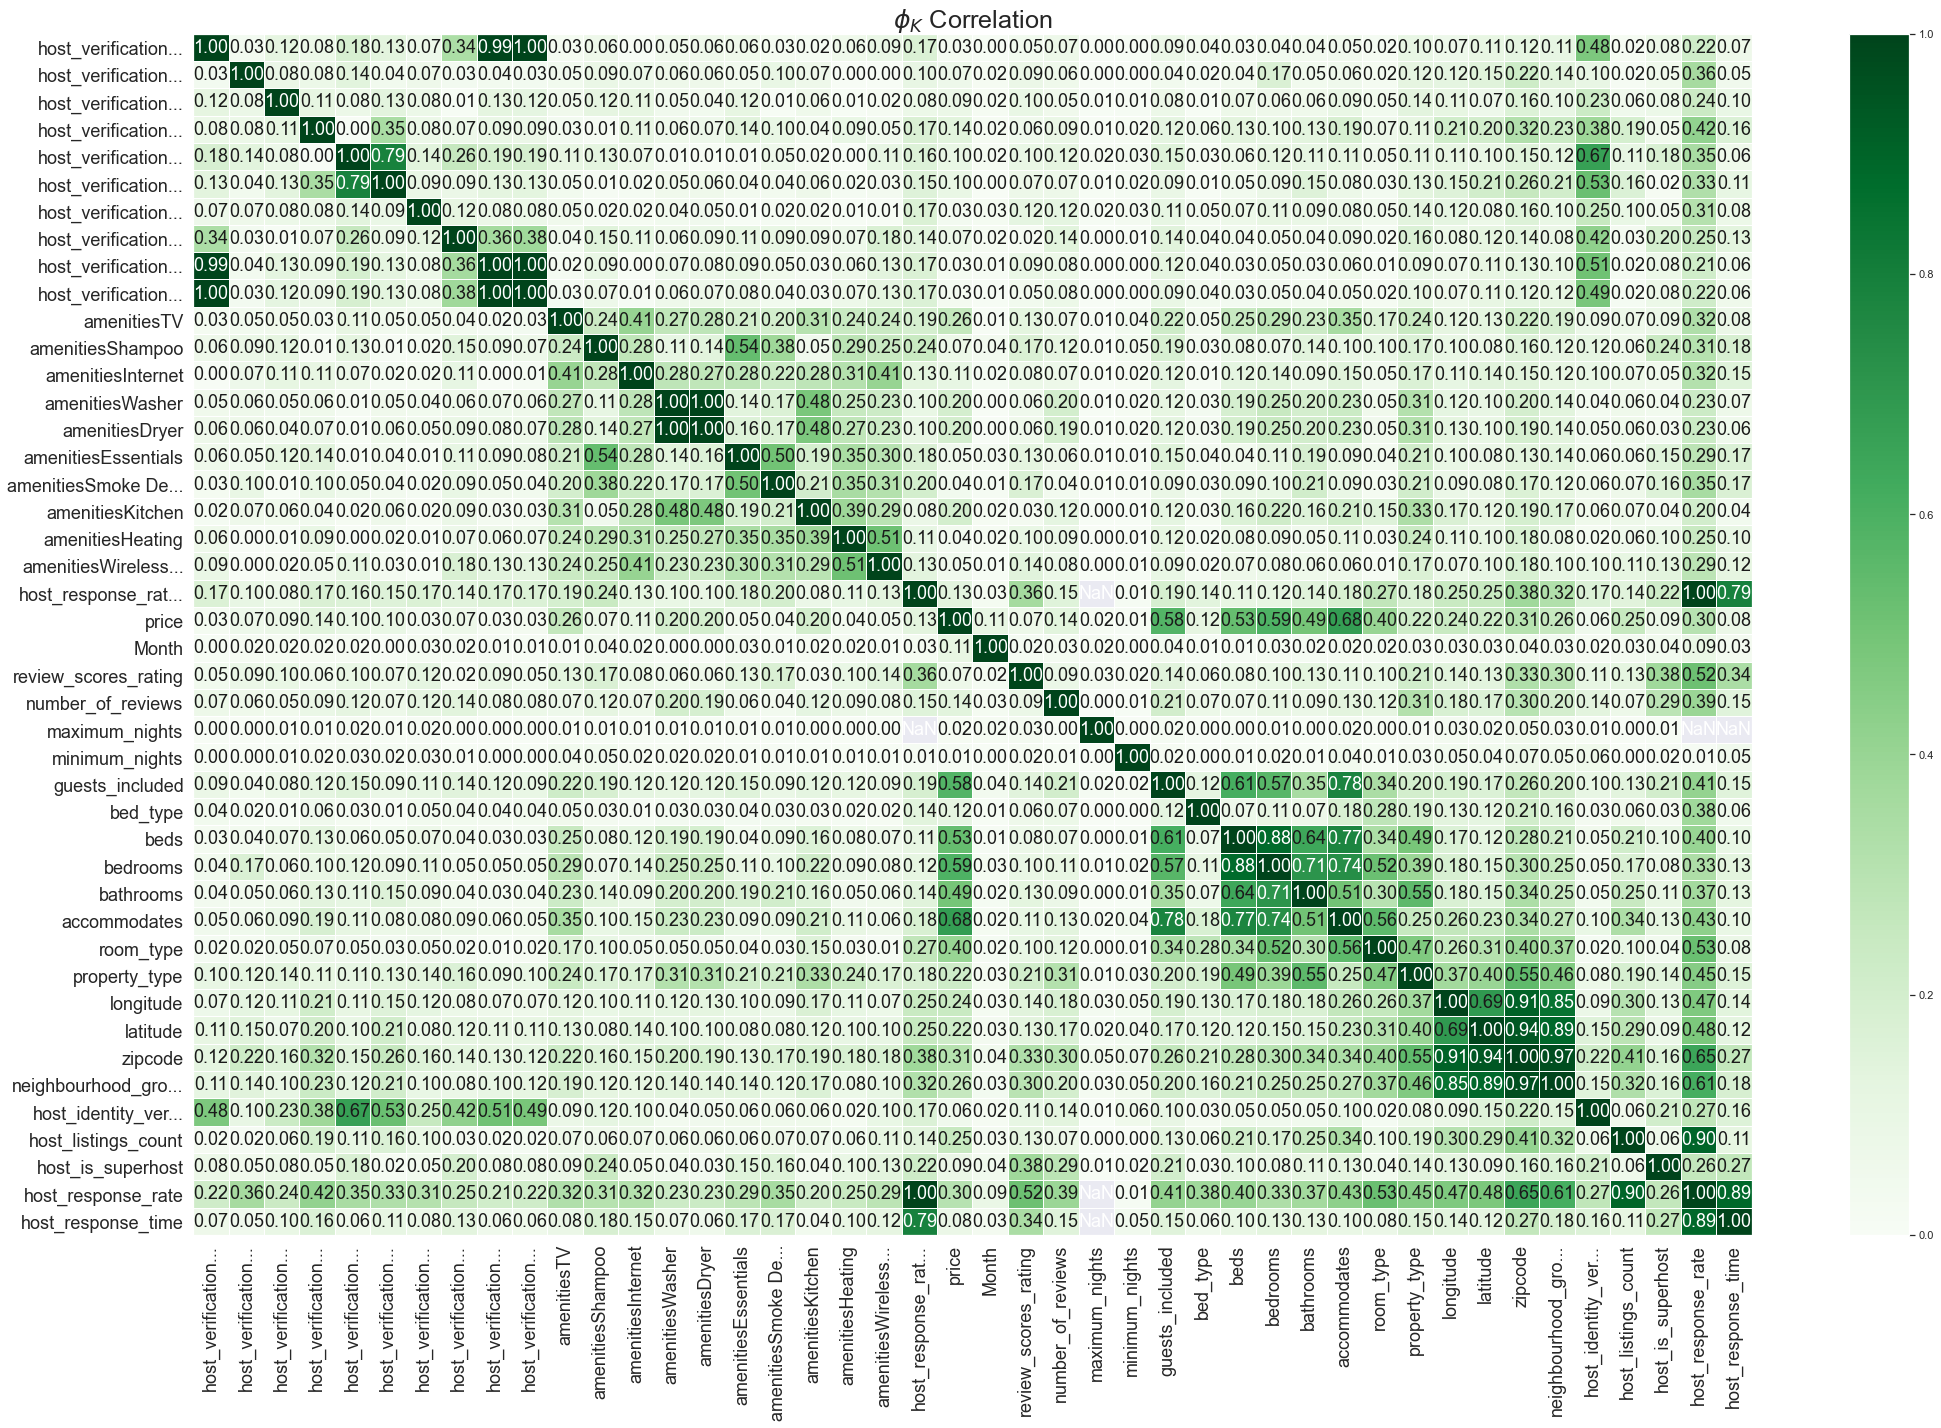

In [15]:
summary = df_eda.drop(['listing_id', 'Year'],axis=1).phik_matrix()
plot_correlation_matrix(summary.values, 
                        x_labels=summary.columns, 
                        y_labels=summary.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"$\phi_K$ Correlation", 
                        fontsize_factor=1.8, 
                        figsize=(30, 20))
plt.show()

In [16]:
display(df_eda.shape)

(934542, 46)

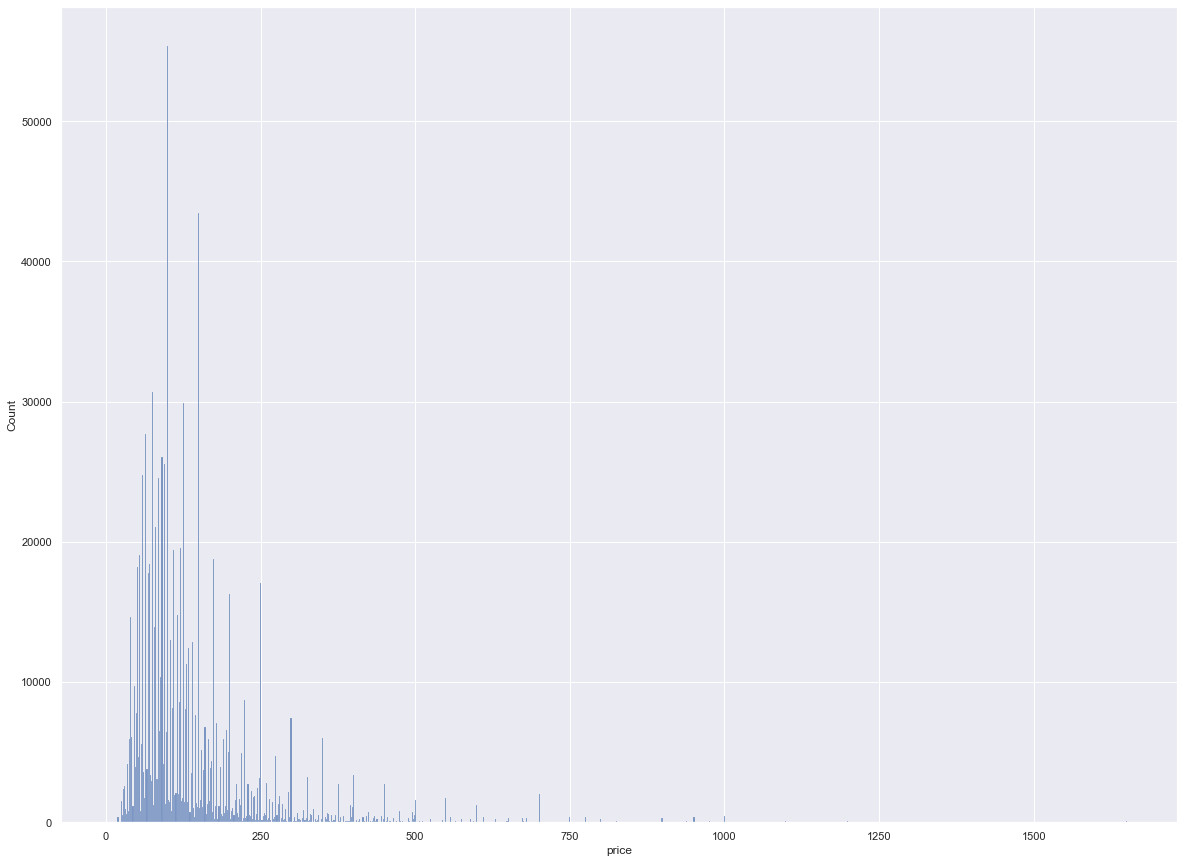

In [17]:
plt.subplots(figsize = (20,15) )
sns.histplot(x='price', data=df_eda)
plt.show()

Generally more normalized than without log scale

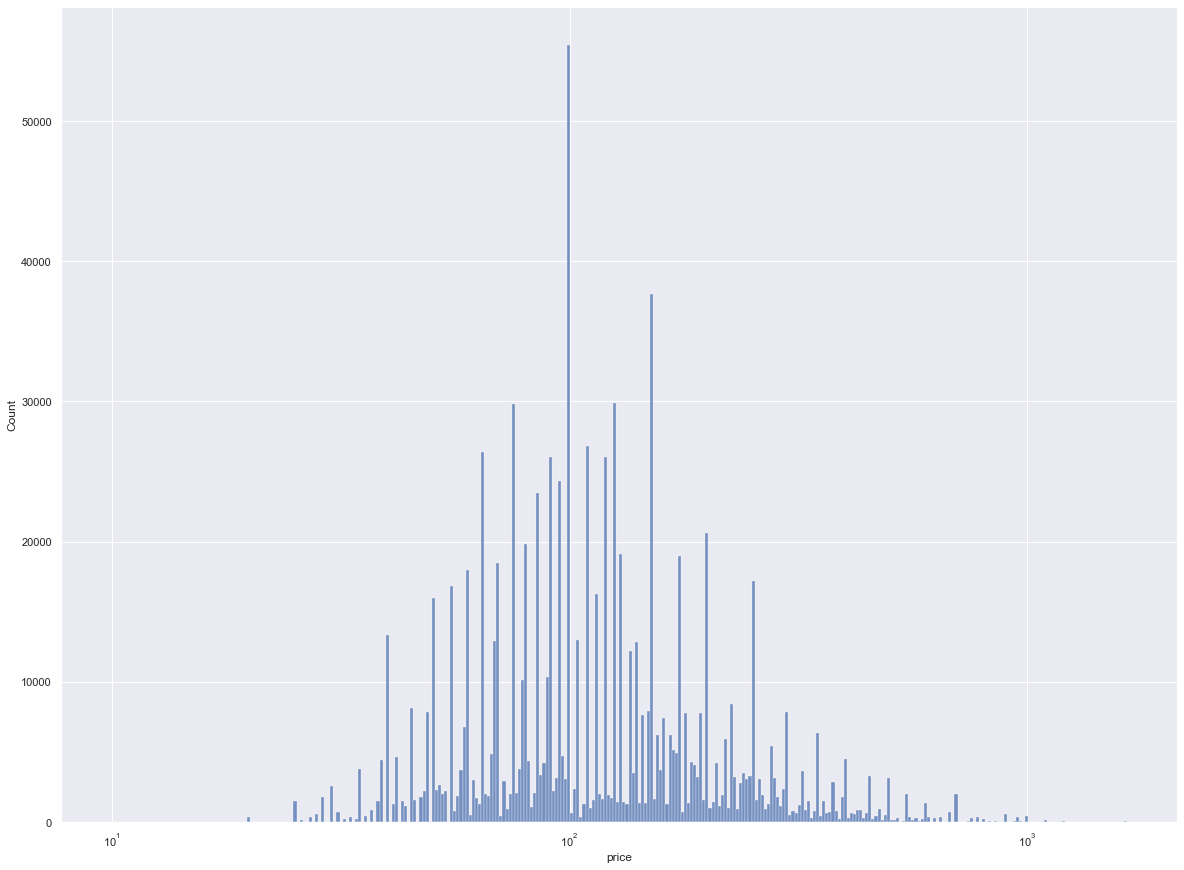

In [18]:
plt.subplots(figsize = (20,15) )
sns.histplot(x='price', data=df_eda,log_scale=True)
plt.show()

In [19]:
mapdf =df_eda.groupby(['longitude', 'latitude'])[['price']].mean().reset_index()
start = (mapdf['latitude'].max() + mapdf['latitude'].min()) / 2
y_start = (mapdf['longitude'].max() + mapdf['longitude'].min()) / 2

begind = (start, y_start)
cmapz = cm.LinearColormap(colors=["#fde725", '#21918c', '#440154'],vmin=mapdf.price.min(),vmax=mapdf.price.max())
map = folium.Map(location=begind, zoom_start=11,tiles="cartodbpositron")

lat = list(mapdf.latitude)
lon = list(mapdf.longitude)
price = list(mapdf.price)

for loc,p in zip(zip(lat, lon), price):
    folium.Circle(
        location=loc,
        radius=10,
        fill=True,
        color= cmapz(p),
        fill_opacity=0.7
    ).add_to(map)

display(map)

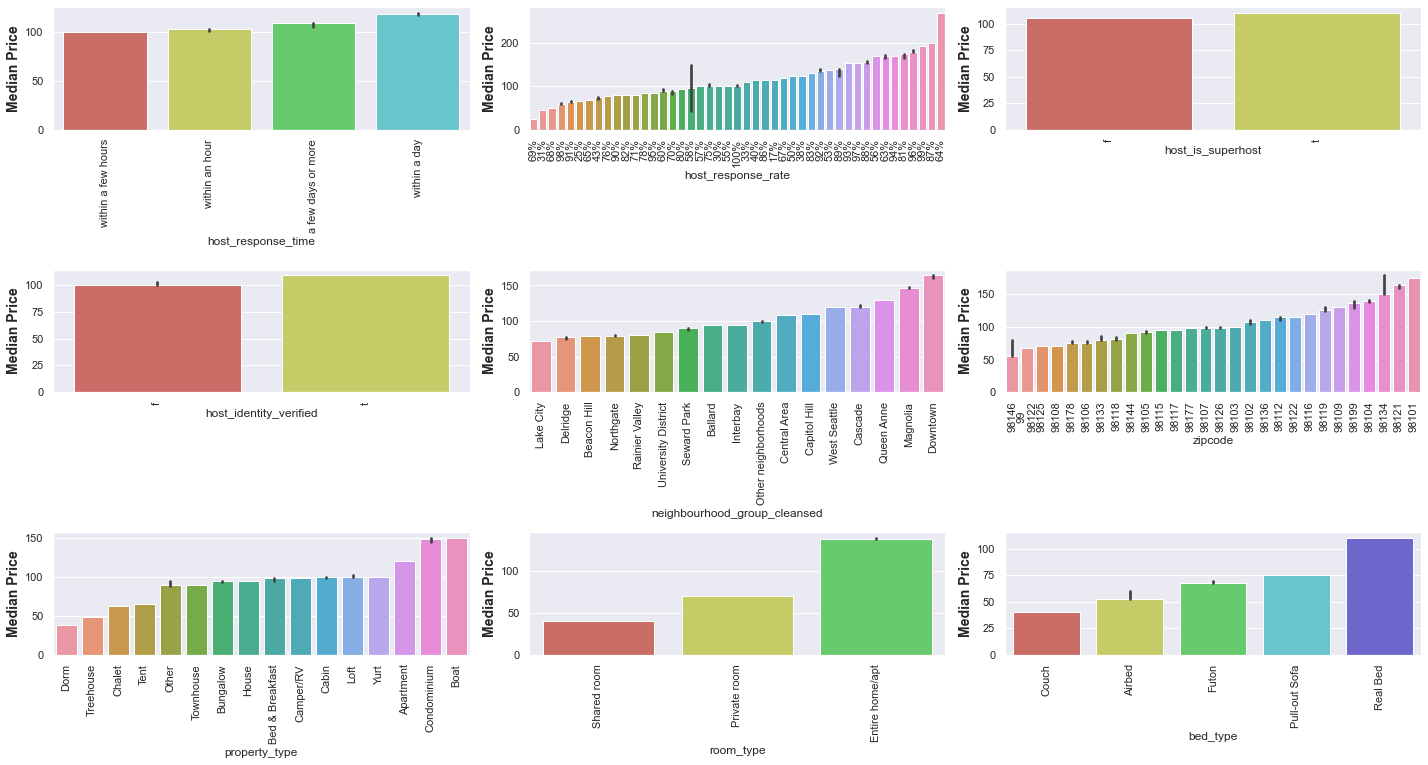

In [20]:
plt.figure(figsize=(20,13))
for i,col in enumerate(df_eda.select_dtypes(exclude=['float64','int64'])):
    sns.set_palette(sns.color_palette("hls"))
    axpr = plt.subplot(4,3,i+1)
    orderby = df_eda.groupby(col)['price'].median().sort_values().index
    # display(orderby)
    sns.barplot(x=col, y ='price', estimator = np.median, data = df_eda, ax = axpr, order=orderby)
    sns.set_style('darkgrid')
    plt.xticks(rotation=90)
    plt.ylabel("Median Price",fontweight = 'bold', fontsize = 14)
    plt.tight_layout()
plt.show()

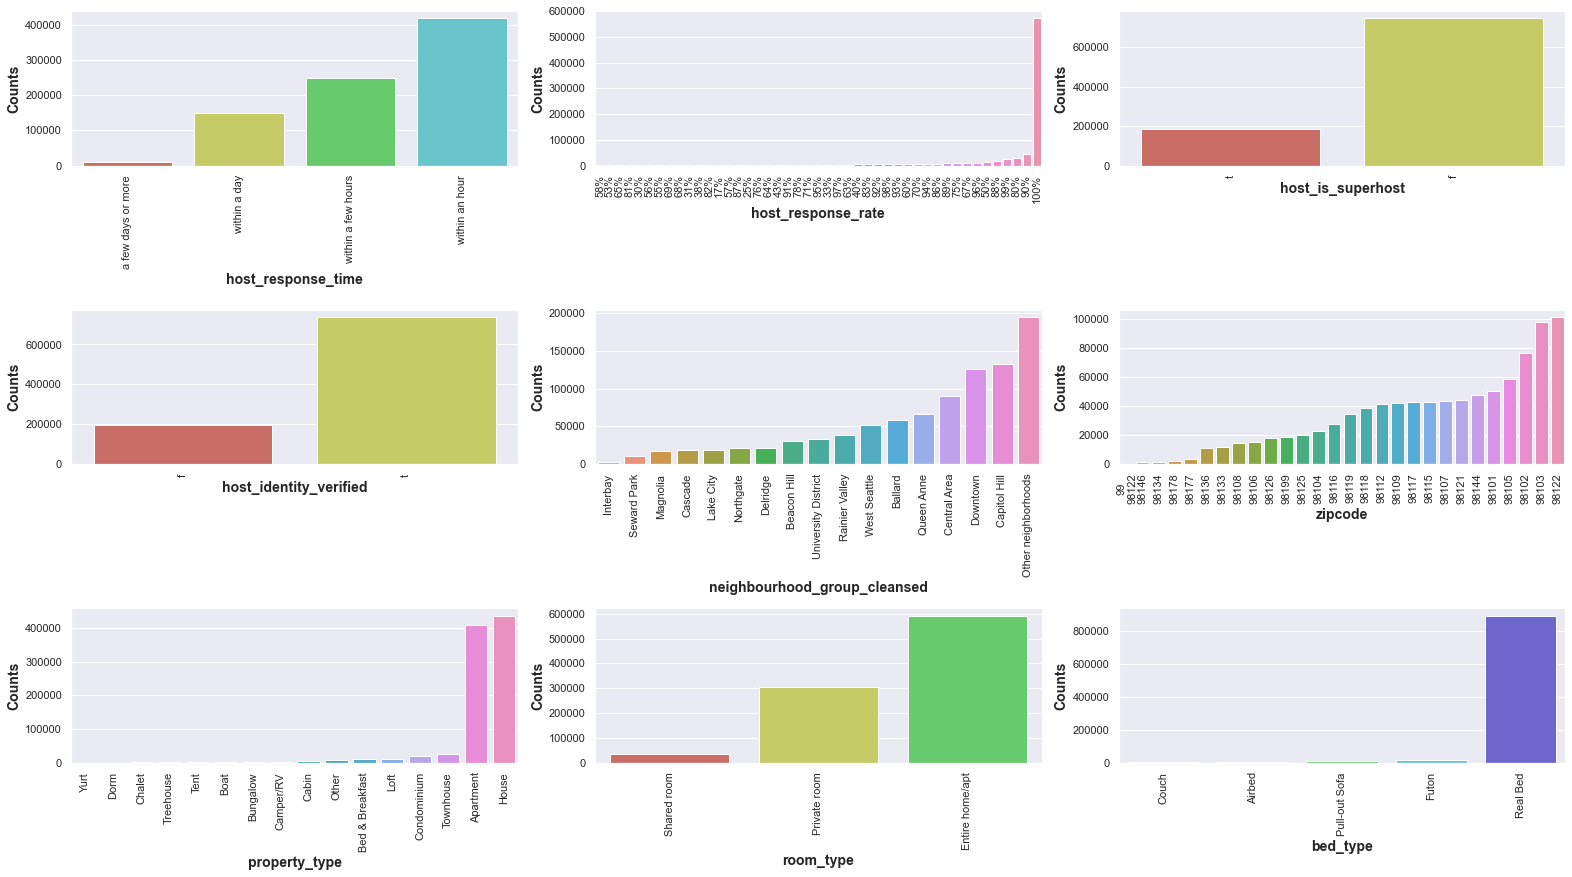

In [21]:
plt.figure(figsize = (22,15))
for y, f in enumerate(df_eda.select_dtypes(exclude=['float64','int64'])):
    axc = plt.subplot(4,3,y+1)
    order2 = df_eda[f].value_counts().sort_values()
    sns.barplot(x=order2.index, y=order2, ax =axc,order=order2.index)
    plt.xlabel(f, fontweight = 'bold', fontsize = 14)
    plt.ylabel(f'Counts', fontweight = 'bold', fontsize = 14)
    plt.tight_layout()
    plt.xticks(rotation=90)

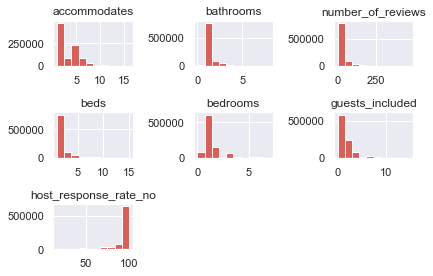

In [38]:
df_eda[['accommodates', 'bathrooms', 'number_of_reviews', 'beds', 'bedrooms', 'guests_included','host_response_rate_no']].hist()
plt.tight_layout()
plt.show()

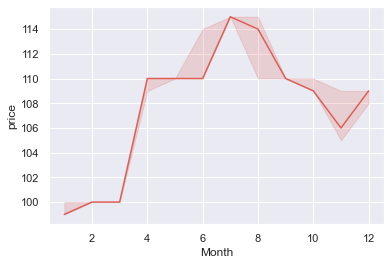

In [44]:
sns.lineplot(x='Month', y= 'price',data=df_eda,estimator=np.median)
plt.show()

# preprocessing

Dropping features we are not using for the model

In [23]:
df.drop(['latitude', 'longitude','listing_id','host_response_rate'],axis=1,inplace=True)

Separating target label from features.
1. Creating hold out test sets.

In [24]:
X,y = df.drop(columns = 'price'),df[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

## Feature Engineering:
- Perform Agglomerative Clustering on `zip_code`

In [127]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

In [ ]:
zip_df = X_train.groupby("zipcode").mean()[['bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating']]



def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    dendrogram(linkage_matrix, **kwargs)

agglom = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

fitted = agglom.fit(zip_df)
plot_dendrogram(fitted, truncate_mode='level', p=3)
plt.show()

We will cut at 100, making it 6 clusters

In [26]:
agglo = AgglomerativeClustering(n_clusters=6) 
zip_df['clust'] = agglo.fit_predict(zip_df)
X_train = pd.merge(X_train, zip_df[['clust']].reset_index(), on='zipcode', how = 'left')
X_test = pd.merge(X_test, zip_df[['clust']].reset_index(), on='zipcode', how = 'left')

Dropping original zipcode

In [27]:
X_train.drop('zipcode',axis=1,inplace=True)
X_test.drop('zipcode',axis=1,inplace=True)

# Modelling

$$X_{scale} =\frac{x_{i}-x_{50}}{x_{75} - x_{25}} $$
<!-- $\frac{\sum_{i=1}^{N}\left(y_{i}-\hat{y}_{i}\right)^{2}}{N}$ -->

In [45]:
class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self,feature):
        self.feature = feature
        self.diction = {}
        for el in self.feature:
            self.diction[el] = LabelEncoder()

    def fit(self,x,y=None):
        x[self.feature] = x[self.feature].fillna('NaN')
        for el in self.feature:
            a = x[el][x[el]!='NaN']
            self.diction[el].fit(a)
        return self
    def transform(self,x,y=None):
        x[self.feature] = x[self.feature].fillna('NaN')
        for el in self.feature:
            a = x[el][x[el]!='NaN']
            b = x[el].to_numpy()
            b[b!='NaN'] = self.diction[el].transform(a)
            x[el]=b
        return x

class Columns(BaseEstimator, TransformerMixin):
    def __init__(self, names=None):
        self.names = names
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X):
        return X[self.names]
ohe_cols = ['neighbourhood_group_cleansed', 'property_type', 'room_type', 'bed_type', 'host_response_time', 'clust']
mask = X_train.columns[np.where((pd.DataFrame(X_train.dtypes == 'object')[0]== True) )  ]
cat_cols = [i for i in mask if i not in ohe_cols]
numeric_cols = [i for i in list(X_train.columns) if i not in list(cat_cols) and not i in list(ohe_cols)]
preprocess = Pipeline([
    ("features", FeatureUnion([
        ('ohe', make_pipeline(Columns(names=ohe_cols), OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)  )),
        ('numeric', make_pipeline(Columns(names=numeric_cols),RobustScaler() )),
        ('categorical', make_pipeline(Columns(names=cat_cols),CustomLabelEncoder(cat_cols)))
    ]))
])

In [75]:
# Function to show cross validation scores for the model purpose is to evaluate model performance
# Cross validate and displays the scores for different metrics on the TRAIN set
rmse = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
def evaluateReg(model,X_train,y_train,name):
    rmse = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    scoring = {
        'MSE':'neg_mean_squared_error',
        'r2':'r2',
        'MAPE':'neg_mean_absolute_percentage_error',
        'RMSE': rmse
    }
    scores = cross_validate(model, X_train, y_train, cv = KFold(n_splits = 2, shuffle = True,random_state=42), scoring = 
    scoring, return_train_score = True, return_estimator = True, n_jobs= -1)
    scores = pd.DataFrame(scores).append(pd.DataFrame(scores).describe().loc[['mean','max']]).drop(['fit_time', 'score_time'],axis=1).round(4)
    scores['estimator']= name
    return pd.DataFrame(scores)

    
def model_evaluation(models, X_train, y_train):
    hist = {}
    for idx, model in enumerate(models):
        model_name = re.findall('[^()]+', str(model.named_steps['Model']))[0]
        # print(model_name)
        cv_hist = evaluateReg(model,X_train,y_train,model_name)
        ax = plt.subplot(3,3,idx+1)
        # performance in a dict
        hist[model_name] = dict(
            cv_mape = cv_hist['test_MAPE'].mean(),
            cv_rmse = cv_hist['test_RMSE'].mean(),
            train_rmse = cv_hist['train_RMSE'].mean(),
            cv_std_rmse = cv_hist['test_RMSE'].std(),
            cv_r2 = cv_hist['test_r2'].mean()
        )
        # train_sizes, train_scores, test_scores= learning_curve(
        #         model,
        #         X_train,
        #         y_train,
        #         cv=KFold(n_splits=2,shuffle=True),
        #         n_jobs=-1,
        #         train_sizes = np.linspace(0.01, 1, 20),
        #     scoring= rmse
        # )

        # train_scores_mean = np.mean(train_scores, axis=1)
        # train_scores_std = np.std(train_scores, axis=1)
        # test_scores_mean = np.mean(test_scores, axis=1)
        # test_scores_std = np.std(test_scores, axis=1)
        
        # sns.lineplot(x=train_sizes ,y =train_scores_mean ,ax=ax,label=str('Train Scores') )
        # sns.lineplot(x = train_sizes ,y = test_scores_mean,ax=ax,label=str('Test Scores'))
        # plt.rc('font', size=14)
        # plt.rc('axes', labelsize=14, titlesize=14)
        # plt.rc('legend', fontsize=14)
        # plt.rc('xtick', labelsize=10)
        # plt.rc('ytick', labelsize=10)
        # if idx ==0 or idx == 3 or idx ==6:
        #     plt.ylabel(f"Root Mean Squared Error")
        # plt.xlabel("Train Sizes")
        # plt.title(re.findall('[^()]+', str(model.named_steps['Model']))[0])
        
        # ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
        #                     train_scores_mean + train_scores_std, alpha=0.1,
        #                     color="r")
        # ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
        #                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
        # plt.tight_layout()
        # ax.legend(loc='best')
        # plt.show()
    display(pd.DataFrame(hist))
    return pd.DataFrame(hist)

In [76]:
dummy = Pipeline([
    ('preprocess', preprocess),
    ('Impute', IterativeImputer(random_state=42)),
    ('Model', DummyRegressor(strategy='median'))
])

ridreg = Pipeline([
    ('preprocess', preprocess),
    ('Impute', IterativeImputer(random_state=42)),
    ('Model', Ridge())
])
knr = Pipeline([
    ('preprocess', preprocess),
    ('Impute', IterativeImputer(random_state=42)),
    ('Model', KNeighborsRegressor())
])
dectreereg =  Pipeline([
    ('preprocess', preprocess),
('Impute', IterativeImputer(random_state=42)),
    ('Model', DecisionTreeRegressor(random_state=42))
])
svm = Pipeline([
    ('preprocess', preprocess),
    ('Impute', IterativeImputer(random_state=42)),
    ('Model', SVR(kernel='linear'))
])
lasso = Pipeline([
    ('preprocess', preprocess),
    ('Impute', IterativeImputer(random_state=42)),
    ('Model', Lasso())
])
gbr = Pipeline([
    ('preprocess', preprocess),
    ('Impute', IterativeImputer(random_state=42)),
    ('Model', GradientBoostingRegressor(random_state=42))
])

DummyRegressor      Lasso      Ridge        SVR  \
cv_mape           -0.485400  -0.323000  -0.318800  -0.264400   
cv_rmse         -109.295925 -67.313825 -65.063750 -68.415700   
train_rmse      -109.295925 -67.295575 -65.041500 -68.410100   
cv_std_rmse        0.089276   0.046383   0.053947   0.062807   
cv_r2             -0.075775   0.591900   0.618725   0.578450   

             KNeighborsRegressor  DecisionTreeRegressor  \
cv_mape                -0.033625              -0.033050   
cv_rmse               -15.368975             -14.809175   
train_rmse            -13.962875             -12.861325   
cv_std_rmse             0.164773               0.027147   
cv_r2                   0.978725               0.980250   

             GradientBoostingRegressor  
cv_mape                      -0.259750  
cv_rmse                     -52.870675  
train_rmse                  -52.826350  
cv_std_rmse                   0.412312  
cv_r2                         0.748275

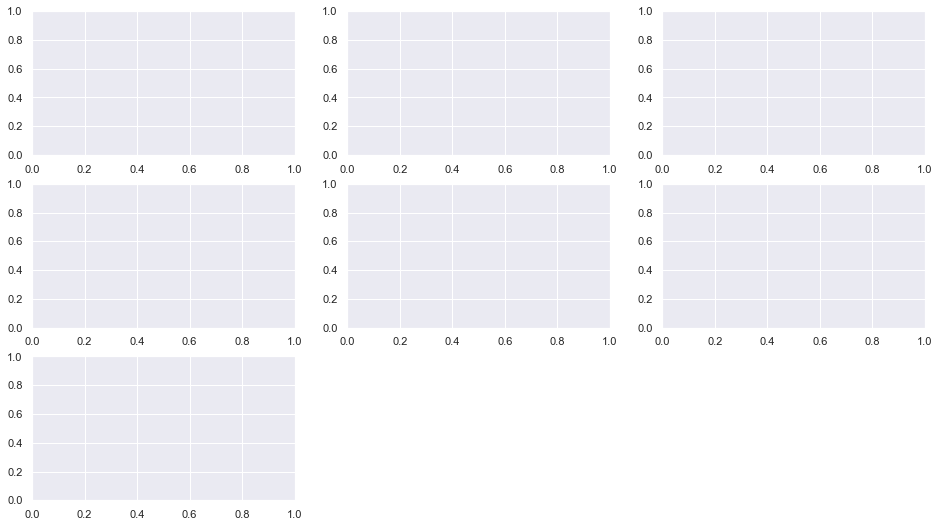

In [77]:
plt.figure(figsize=(16,9))
scores_final = model_evaluation([dummy, lasso,ridreg,svm,knr,dectreereg,gbr],X_train,y_train)

Final model: Decision tree regressor

## Model Improvement

TransformedTargetregressor

In [92]:
model = Pipeline([
    ('Prep',preprocess),
    ('Impute', IterativeImputer(random_state=42)),
    ('Model', TransformedTargetRegressor(DecisionTreeRegressor(random_state=42),func=np.log,inverse_func=np.expm1))
])

In [ ]:
scores_final = model_evaluation([model],X_train,y_train)

In [95]:
model_rfe = Pipeline([
    ('Prep',preprocess),
    ('Impute', IterativeImputer(random_state=42)),
    ('RFE', RFE(DecisionTreeRegressor(random_state=42), n_features_to_select=0.5)),
    ('Model', TransformedTargetRegressor(DecisionTreeRegressor(random_state=42),func=np.log,inverse_func=np.exp))
])

In [ ]:
rfe_score = model_evaluation([model_rfe],X_train,y_train)

## Validation curve before tuning

In [78]:
from sklearn.model_selection import validation_curve
rmse = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
def plot_vc(model, X_train, y_train, param_name, param_range,ax):
  train_scores, test_scores = validation_curve(model, X_train, y_train,cv=KFold(shuffle=True,random_state = 42,n_splits=2), param_name = param_name, param_range = param_range, scoring=rmse, n_jobs = -1)
  sns.lineplot(x=np.tile(param_range, train_scores.shape[1]), y=train_scores.flatten(), ax = ax, label = 'Train Scores')
  sns.lineplot(x=np.tile(param_range, test_scores.shape[1]), y=test_scores.flatten(), ax = ax,label = 'CV Scores')
  ax.set_title(f"V. Curve ({param_name})")
  ax.set_ylabel("RMSE")
  ax.set_xlabel(f"{param_name}")

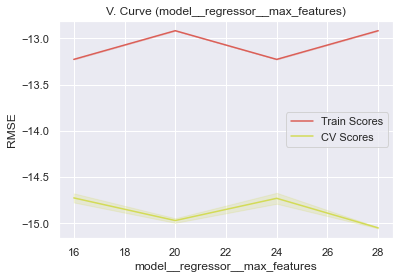

In [79]:
plot_vc(model,X_train,y_train,'Model__regressor__max_features',[16,20,24,28],plt.gca())

## Hyperparameter tuning

In [101]:
param_copy = {
    "Model__regressor__max_features" : [15,20],
    "Model__regressor__max_depth" : [24,28],
}
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
result = HalvingGridSearchCV(model,param_copy,cv=2,random_state=42,scoring=rmse,n_jobs=-1)

In [104]:
result.fit(X_train,y_train)

HalvingGridSearchCV(cv=2,
                    estimator=Pipeline(steps=[('Prep',
                                               Pipeline(steps=[('features',
                                                                FeatureUnion(transformer_list=[('ohe',
                                                                                                Pipeline(steps=[('columns',
                                                                                                                 Columns(names=['neighbourhood_group_cleansed',
                                                                                                                                'property_type',
                                                                                                                                'room_type',
                                                                                                                                'bed_type',
                              

In [107]:
result.best_score_

-15.35820951021999

In [111]:
final_model = Pipeline([
    ('Prep',preprocess),
    ('Impute', IterativeImputer(random_state=42)),
    ('RFE', RFE(DecisionTreeRegressor(random_state=42), n_features_to_select=0.5)),
    ('Model', TransformedTargetRegressor(DecisionTreeRegressor(random_state=42),func=np.log,inverse_func=np.exp))
]).fit(X_train,y_train)

Hyperparameter tuning did not really improve, hence we will go with original model

Final model evaluation

In [112]:
preds = final_model.predict(X_test)
print(mean_absolute_error(y_test,preds))
print(mean_absolute_percentage_error(y_test,preds))
print(mean_squared_error(y_test,preds,squared=False))
print(r2_score(y_test,preds))

4.900814315739521
0.03189636677221292
14.577159630117269
0.9804598912183169



Residual plot

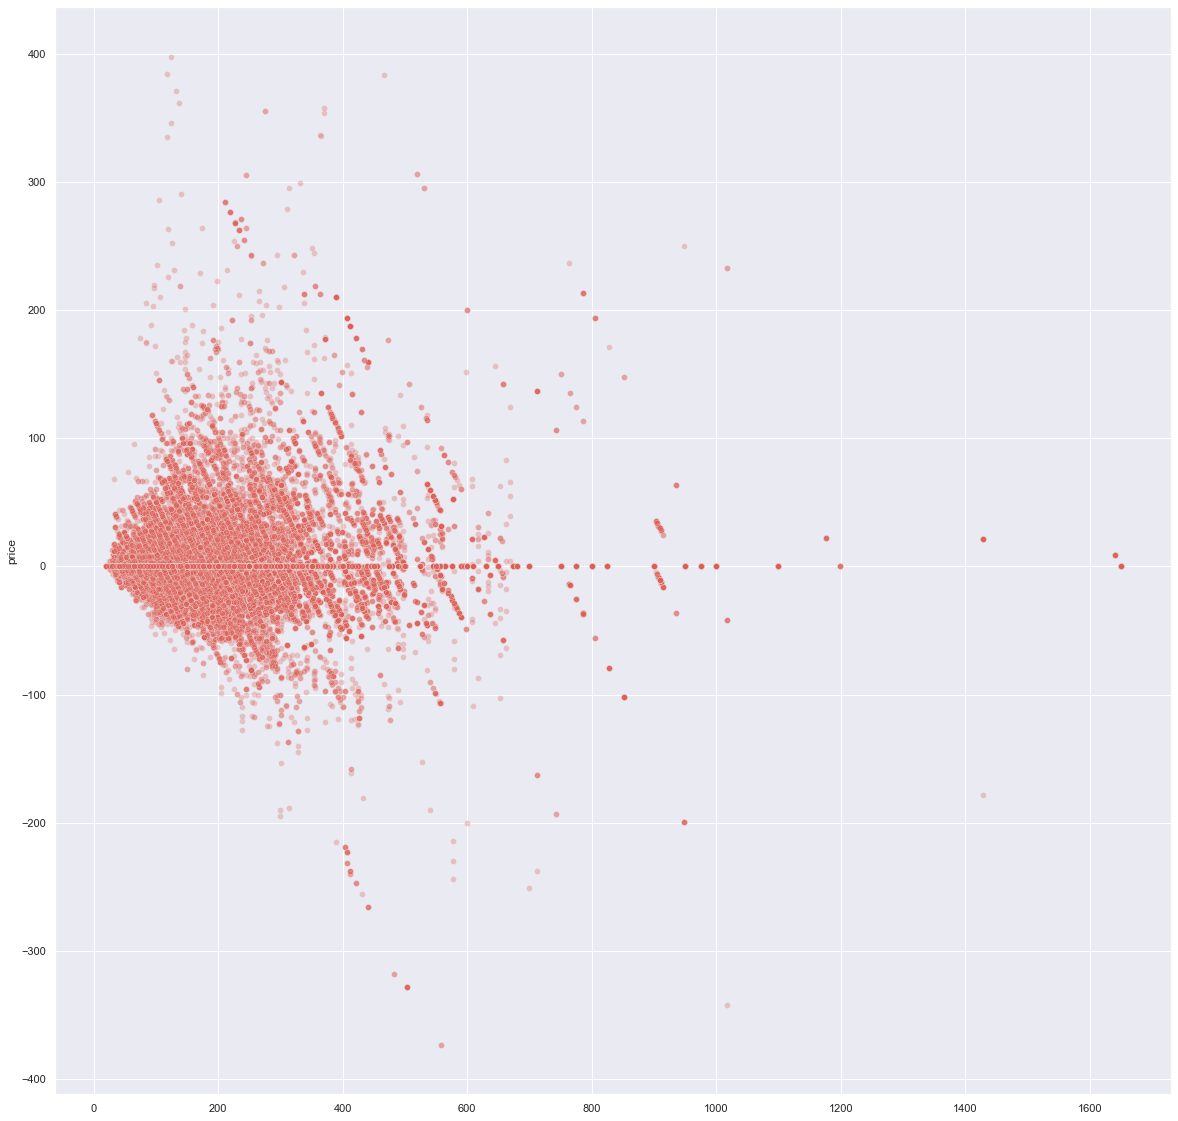

In [125]:
residuals = y_test-preds
plt.subplots(figsize=(20,20))
sns.scatterplot(x = preds.flatten(),y =residuals.price,alpha=.3)
# residuals

plt.show()

In [126]:
np.mean(residuals)

price    0.393112
dtype: float64